In [1]:
import re
from sklearn.base import BaseEstimator, clone, RegressorMixin
from sklearn.linear_model import MultiTaskElasticNetCV
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from data_manipulations import *

In [2]:
train_features = pl.read_parquet('train_features.parquet')
train_targets = pl.read_parquet('train_targets.parquet')
test_features = pl.read_parquet('test_features.parquet')
test_targets = pl.read_parquet('test_targets.parquet')

data = prepare_data_for_ml(
    train_features, train_targets, test_features, test_targets,
)

In [3]:
# def restrict(frame, heads=(25, 20)):
#     keys = frame.columns[:2]
#     temp = join_many((
#         frame.select(keys[0]).unique().sort(by=keys[0]).head(heads[0]),
#         frame.select(keys[1]).unique().sort(by=keys[1]).head(heads[1]),
#     ), how='cross')
#     return frame.join(temp, on=keys)

# train_features = restrict(train_features)
# train_targets = restrict(train_targets)
# test_features = restrict(test_features)
# test_targets = restrict(test_targets)

# data = prepare_data_for_ml(train_features, train_targets, test_features, test_targets)
# data['train_features_rect'].shape, data['train_targets_rect'].shape

# Model

In [4]:
class SparseEN(BaseEstimator, RegressorMixin):
    def __init__(
        self,
        sparsity=0.4,
        l1_ratio=0.5,  # not 0.0
    ):
        self.model = MultiTaskElasticNetCV(
            l1_ratio=l1_ratio,  # 0.5
            fit_intercept=False,  # True
            n_alphas=50,  # 100
            cv=3,
            random_state=0,
            max_iter=2000,  # 1000
        )
        self.sparsity = sparsity
        self.l1_ratio = l1_ratio
        self.supports = None
        self.models = None

    def fit(self, features, targets):
        model = clone(self.model)
        model.fit(StandardScaler().fit_transform(features), targets)
        bipartite, _ = get_support(model.coef_, self.sparsity)
        assert (bipartite.sum(axis=1) > 0).all()
        self.supports = get_connected_components_supports(bipartite)

        self.models = []
        for support_features, support_targets in self.supports:
            model = make_pipeline(StandardScaler(), clone(self.model))
            model.fit(features[:, support_features], targets[:, support_targets])
            self.models.append((model, support_features, support_targets))
        return self

    def predict(self, features):
        predictions = np.zeros(features.shape)  # bof
        for model, support_features, support_targets in self.models:
            predictions[:, support_targets] = model.predict(features[:, support_features])
        return predictions

# Learning curves and connected components

  0%|          | 0/8 [00:00<?, ?it/s]

sparsity: 0.99


/home/tibo/.local/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:673: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006973862713831186, tolerance: 0.0005104003947135309
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/tibo/.local/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:673: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007180851159647728, tolerance: 0.0005230400883078836
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/tibo/.local/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:673: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006973862713831186, tolerance: 0.0005104003947135309
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/tibo/.local/lib/python3.13/site-pa

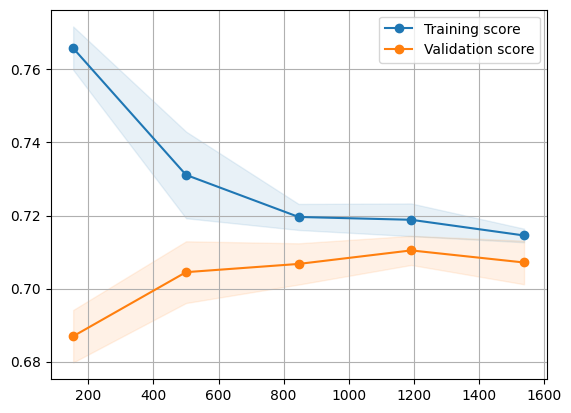

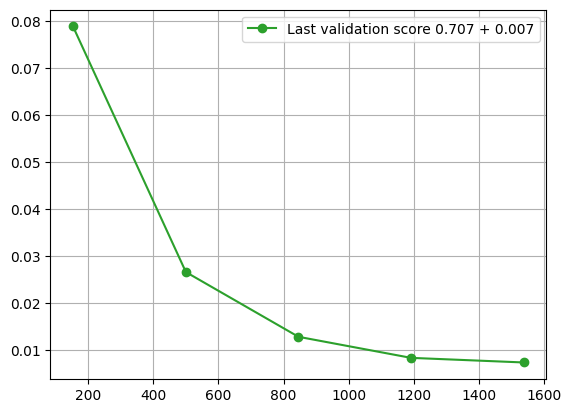

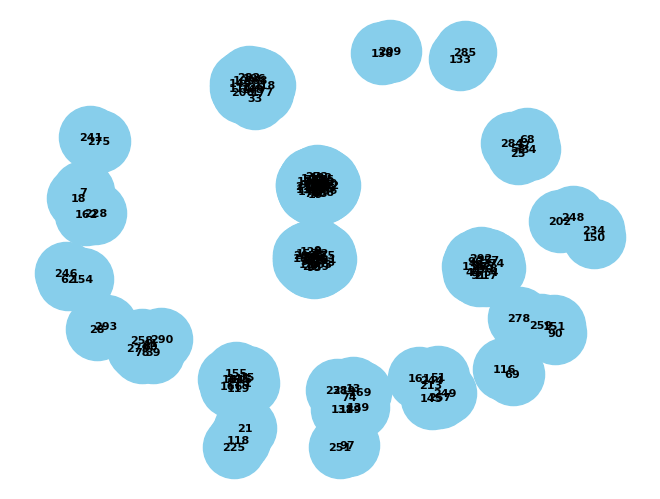

 12%|█▎        | 1/8 [02:53<20:15, 173.71s/it]

22 connected components
----------------------------------------------------------------------------------------------------
sparsity: 0.98


/home/tibo/.local/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:673: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006973862713831186, tolerance: 0.0005104003947135309
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/tibo/.local/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:673: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007180851159647728, tolerance: 0.0005230400883078836
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/tibo/.local/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:673: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006973862713831186, tolerance: 0.0005104003947135309
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/tibo/.local/lib/python3.13/site-pa

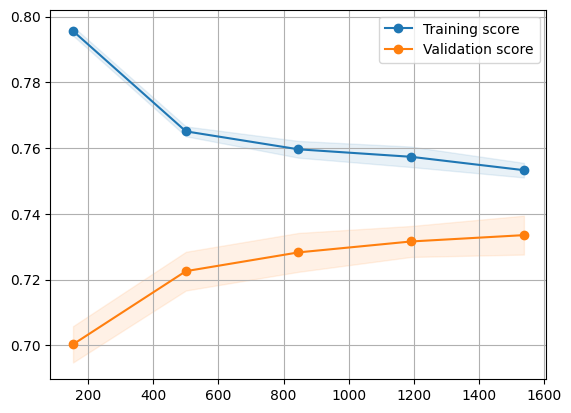

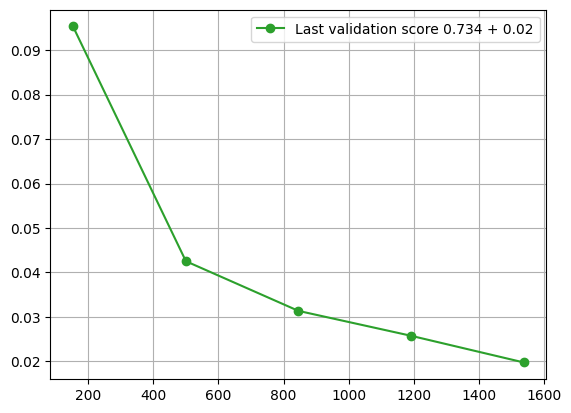

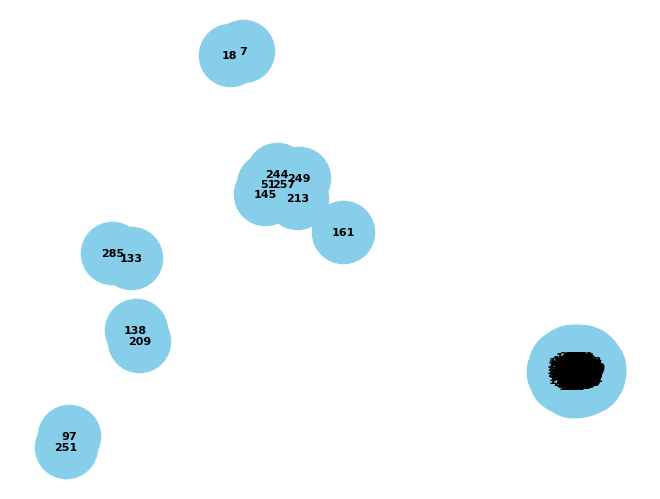

 25%|██▌       | 2/8 [06:10<18:42, 187.07s/it]

6 connected components
----------------------------------------------------------------------------------------------------
sparsity: 0.97


/home/tibo/.local/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:673: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006973862713831186, tolerance: 0.0005104003947135309
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/tibo/.local/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:673: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006973862713831186, tolerance: 0.0005104003947135309
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/tibo/.local/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:673: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006973862713831186, tolerance: 0.0005104003947135309
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/tibo/.local/lib/python3.13/site-pa

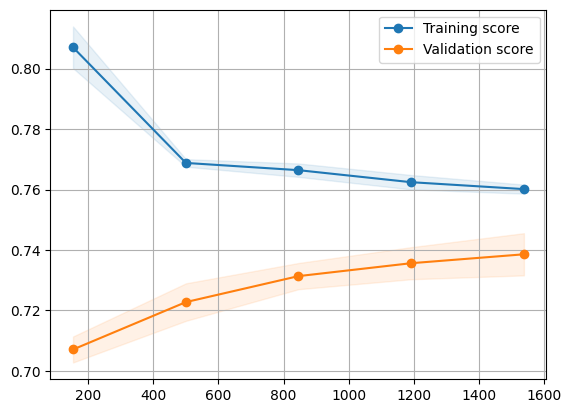

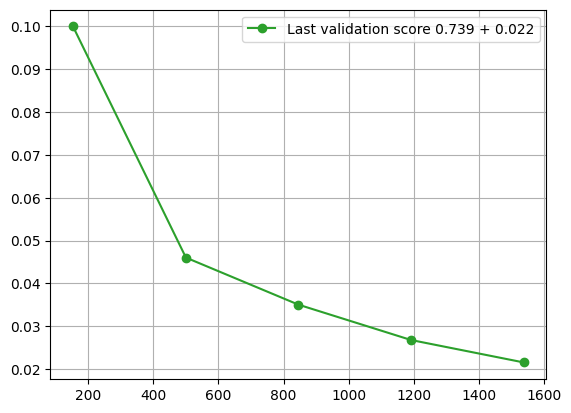

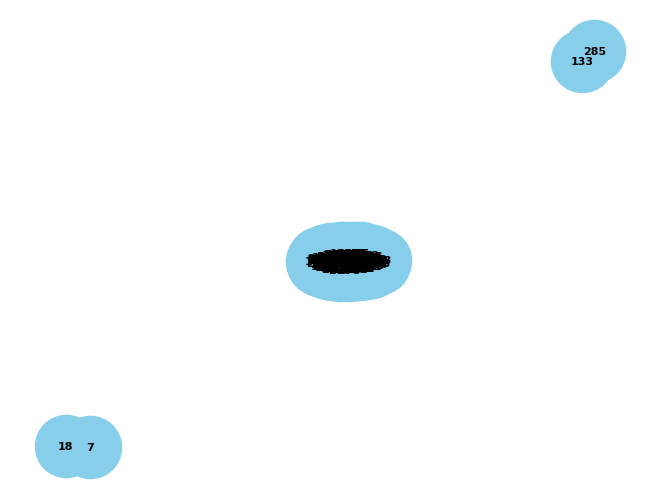

 38%|███▊      | 3/8 [09:46<16:41, 200.36s/it]

3 connected components
----------------------------------------------------------------------------------------------------
sparsity: 0.96


/home/tibo/.local/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:673: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006973862713831186, tolerance: 0.0005104003947135309
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/tibo/.local/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:673: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006973862713831186, tolerance: 0.0005104003947135309
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/tibo/.local/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:673: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006973862713831186, tolerance: 0.0005104003947135309
  model = cd_fast.enet_coordinate_descent_multi_task(
/home/tibo/.local/lib/python3.13/site-pa

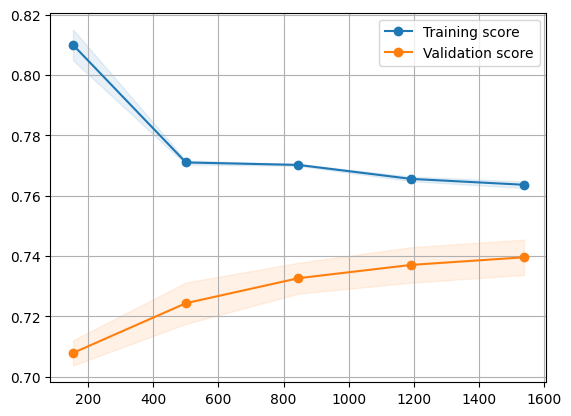

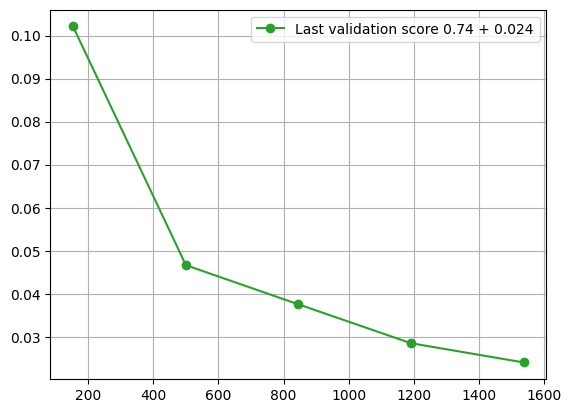

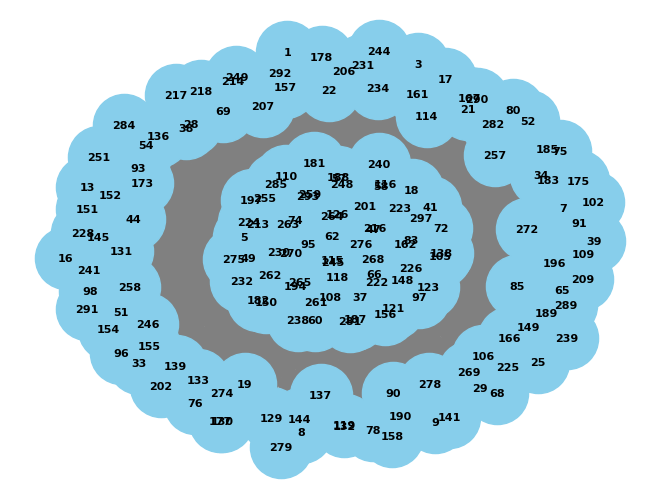

 38%|███▊      | 3/8 [13:31<22:32, 270.59s/it]

1 connected components
CPU times: user 25min 14s, sys: 1.34 s, total: 25min 16s
Wall time: 13min 31s


In [5]:
%%time

sparsities = [0.99, 0.98, 0.97, 0.96, 0.95, 0.90, 0.80, 0.70]
for sparsity in tqdm(sparsities):
    print(f'sparsity: {sparsity}')
    model = SparseEN(sparsity=sparsity)

    # learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        model,
        data['train_features_rect'].to_numpy(),
        data['train_targets_rect'].to_numpy(),
        cv=5,
        scoring=scoring,
        n_jobs=-1,
    )

    plot_learning_curve(train_sizes, train_scores, test_scores)
    plt.show()

    # number of connected components
    fitted_model, _ = fit_predict_sklearn_model(
        train_features, train_targets, test_features, test_targets,
        model,
    )

    graph = nx.Graph()
    for component_features, component_targets in fitted_model.supports:
        for feature, is_feature in zip(data['features'], component_features):
            for target, is_target in zip(data['targets'], component_targets):
                if is_feature and is_target:
                    graph.add_edge(feature, target)
                    graph.add_edge(target, feature)

    plt.figure()
    nx.draw(
        graph,
        with_labels=True,
        node_color='skyblue',
        node_size=2000,
        font_size=8,
        font_weight='bold',
        edge_color='gray',
    )
    plt.show()
    n_components = len(fitted_model.supports)
    print(f'{n_components} connected components')
    if n_components == 1:
        break
    print('-' * 100)